## Bibliotecas e módulos

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

#from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Funções utilizadas pelo método FKM

In [6]:
#critério inicialização dos lambdas-----------------------------
def compute_lambdas(data,mu,beta):
    expo = 2.0/(beta-1.0)
    m,_ = data.shape
    k,_ = mu.shape
    lamb = np.zeros((m,k))
    diss = np.zeros((k))
    for i in range(0,m):
        for j in range(0,k):
            diss[j] = np.linalg.norm( data[i,:] - mu[j,:] )+0.0001
        
        for j in range(0,k):
            s = 0
            for ell in range(0,k):
                s += ( diss[j] / diss[ell] )**expo
            lamb[i,j] = 1/s
    return lamb


#Atualização dos centroides
def compute_mu(data,lamb,beta):
    m,dim = data.shape
    _,k = lamb.shape
    mu = np.zeros((k,dim))
    for j in range(0,k):
        num = np.zeros((dim))
        den = 0
        for i in range(0,m):
            num[:] += (lamb[i,j]**beta) * data[i,:]
            den += (lamb[i,j]**beta)
        mu[j,:] = num[:]/den
    return mu


#critério inicialização----------------------------------------
def init_centroids(data,k):
    m,dim = data.shape
    bestCost = 10**10
    mu = np.zeros((k,dim)) #inicializacao dos 'mus' [usando matriz]
    bestMu = np.zeros((k,dim))
    for _ in range(0, int(np.ceil(0.1*m)) ):
        randPos = np.random.randint(0,m,k)
        mu = data[randPos,:]
        cost = intra_cluster_var(data,mu)
        if cost < bestCost:
            bestCost = cost
            bestMu = np.copy(mu)
    return bestMu


#critério inicialização----------------------------------------
def intra_cluster_var(data,mu):
    m,_ = data.shape
    k,_ = mu.shape
    
    totalCost = np.zeros((k))
    countClus = np.zeros((k))
    for i in range(0,m):
        diss = np.zeros((k))
        for j in range(0,k):
            diss[j] = np.linalg.norm( data[i,:] - mu[j,:] )**2
        pos = np.argmin(diss)
        totalCost[pos] += diss[pos]
        countClus[pos] += 1
    clusterVar = (1/m) * np.sum(totalCost)

    return clusterVar


#Função para definir o agrupamento segundo o lambda---
def assign_label(lamb):
    m,_ = lamb.shape
    lab = np.zeros((m))
    for i in range(0,m): lab[i] = np.argmax(lamb[i,:])
    return lab


#Método Fuzzy K-Means---------------------------------
def fuzzy_kmeans(data,k,beta,epsilon):
    #Inicialização do mu e lambda
    mu = init_centroids(data,k)
    lamb = compute_lambdas(data,mu,beta)

    while True:  #inicio do processo iterativo ("while True para simular um laço do-while")
        mu_old = np.copy(mu) #Para fins de comparação/convergênca
        mu = compute_mu(data,lamb,beta) #Cálculo dos centroides
        lamb = compute_lambdas(data,mu,beta) #Atualização dos lambdas
        
        if np.linalg.norm( mu - mu_old ) < epsilon: break #Teste de convergência
        
    #Definição dos agrupamentos segundo as pertinencias
    lab = assign_label(lamb)
    return lab

## Simulação e visualização dos dados

[(-7.517526577754113, 5.101942181379384),
 (-11.825078554442136, 5.546385296559158)]

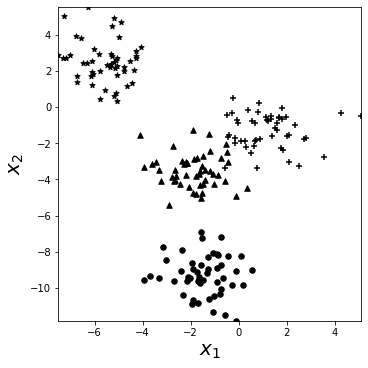

In [30]:
np.random.seed(2)
#np.random.seed(0)
agrupamentos = 4
x, y = make_blobs(n_features=2, centers=agrupamentos, n_samples=200)

marr = ['o','+','^','*']
vecMar = []
for i in y: vecMar.append(marr[i])
    
FS = (5,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

#Subgráficos...
ax = fig.add_subplot(spec[0, 0])
for i in range(agrupamentos):
    pos =  np.where(y == i)
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c='k', s=30)

ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set(xlim=(np.min(x[:,0]), np.max(x[:,0])), ylim=(np.min(x[:,1]), np.max(x[:,1])))

## Parametrização

In [31]:
path_out = 'KM-FKM_clus4.png'
n_clusters = 5
epsilon = 0.0001
beta = 5.0
#----------

#Execução dos algoritmo FKM
clusFKM = fuzzy_kmeans(x,n_clusters,beta,epsilon)

#Instanciação e execução dos algoritmo K-Médias
km = KMeans(n_clusters=n_clusters, max_iter=1000, tol=epsilon)
clusKM = km.fit_predict(x)

## Visualização do resultado de agrupamento

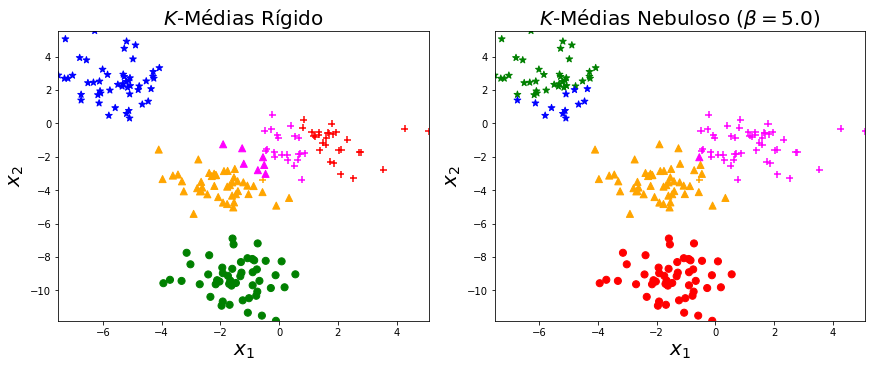

In [32]:
FS = (12,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

coll = ['red','blue','green','orange','magenta','cyan','darkred','grey']
marr = ['o','+','^','*','D','x','p','h']

#Subgráfico 1 (K-Médias)
ax = fig.add_subplot(spec[0,0])
for i in range(n_clusters):
    pos = np.where( y == i )
    vecCol = []
    for j in pos[0]: vecCol.append(coll[ int(clusKM[j]) ])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCol, s=50)
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title('$K$-Médias Rígido', fontsize=20)
ax.set(xlim=(np.min(x[:,0]), np.max(x[:,0])), ylim=(np.min(x[:,1]), np.max(x[:,1])))
    
    
#Subgráfico 2 (FKM)
ax = fig.add_subplot(spec[0,1])
for i in range(n_clusters):
    pos = np.where( y == i )
    vecCol = []
    for j in pos[0]: vecCol.append(coll[ int(clusFKM[j]) ])
    ax.scatter(x[pos, 0], x[pos, 1], marker=marr[i], c=vecCol, s=50)
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title('$K$-Médias Nebuloso ('+r'$\beta = $' + str(beta)+')', fontsize=20)
ax.set(xlim=(np.min(x[:,0]), np.max(x[:,0])), ylim=(np.min(x[:,1]), np.max(x[:,1])))


plt.savefig(path_out,dpi=300)
plt.show()